Find this notebook here: https://github.com/vitalv/glovo-courier/blob/master/courier.ipynb

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 
sb.set_style("whitegrid", {'axes.grid' : False})
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV

## Exploratory Analysis and Data Munging

In [4]:
lifetime = pd.read_csv('Courier_lifetime_data.csv')
weekly = pd.read_csv('Courier_weekly_data.csv')

In [5]:
len(set(list(lifetime.courier)))

7524

In [6]:
len(set(list(weekly.courier)))

759

* only approximately 1/10 of the couriers have weekly data

### Explore distributions of weekly data

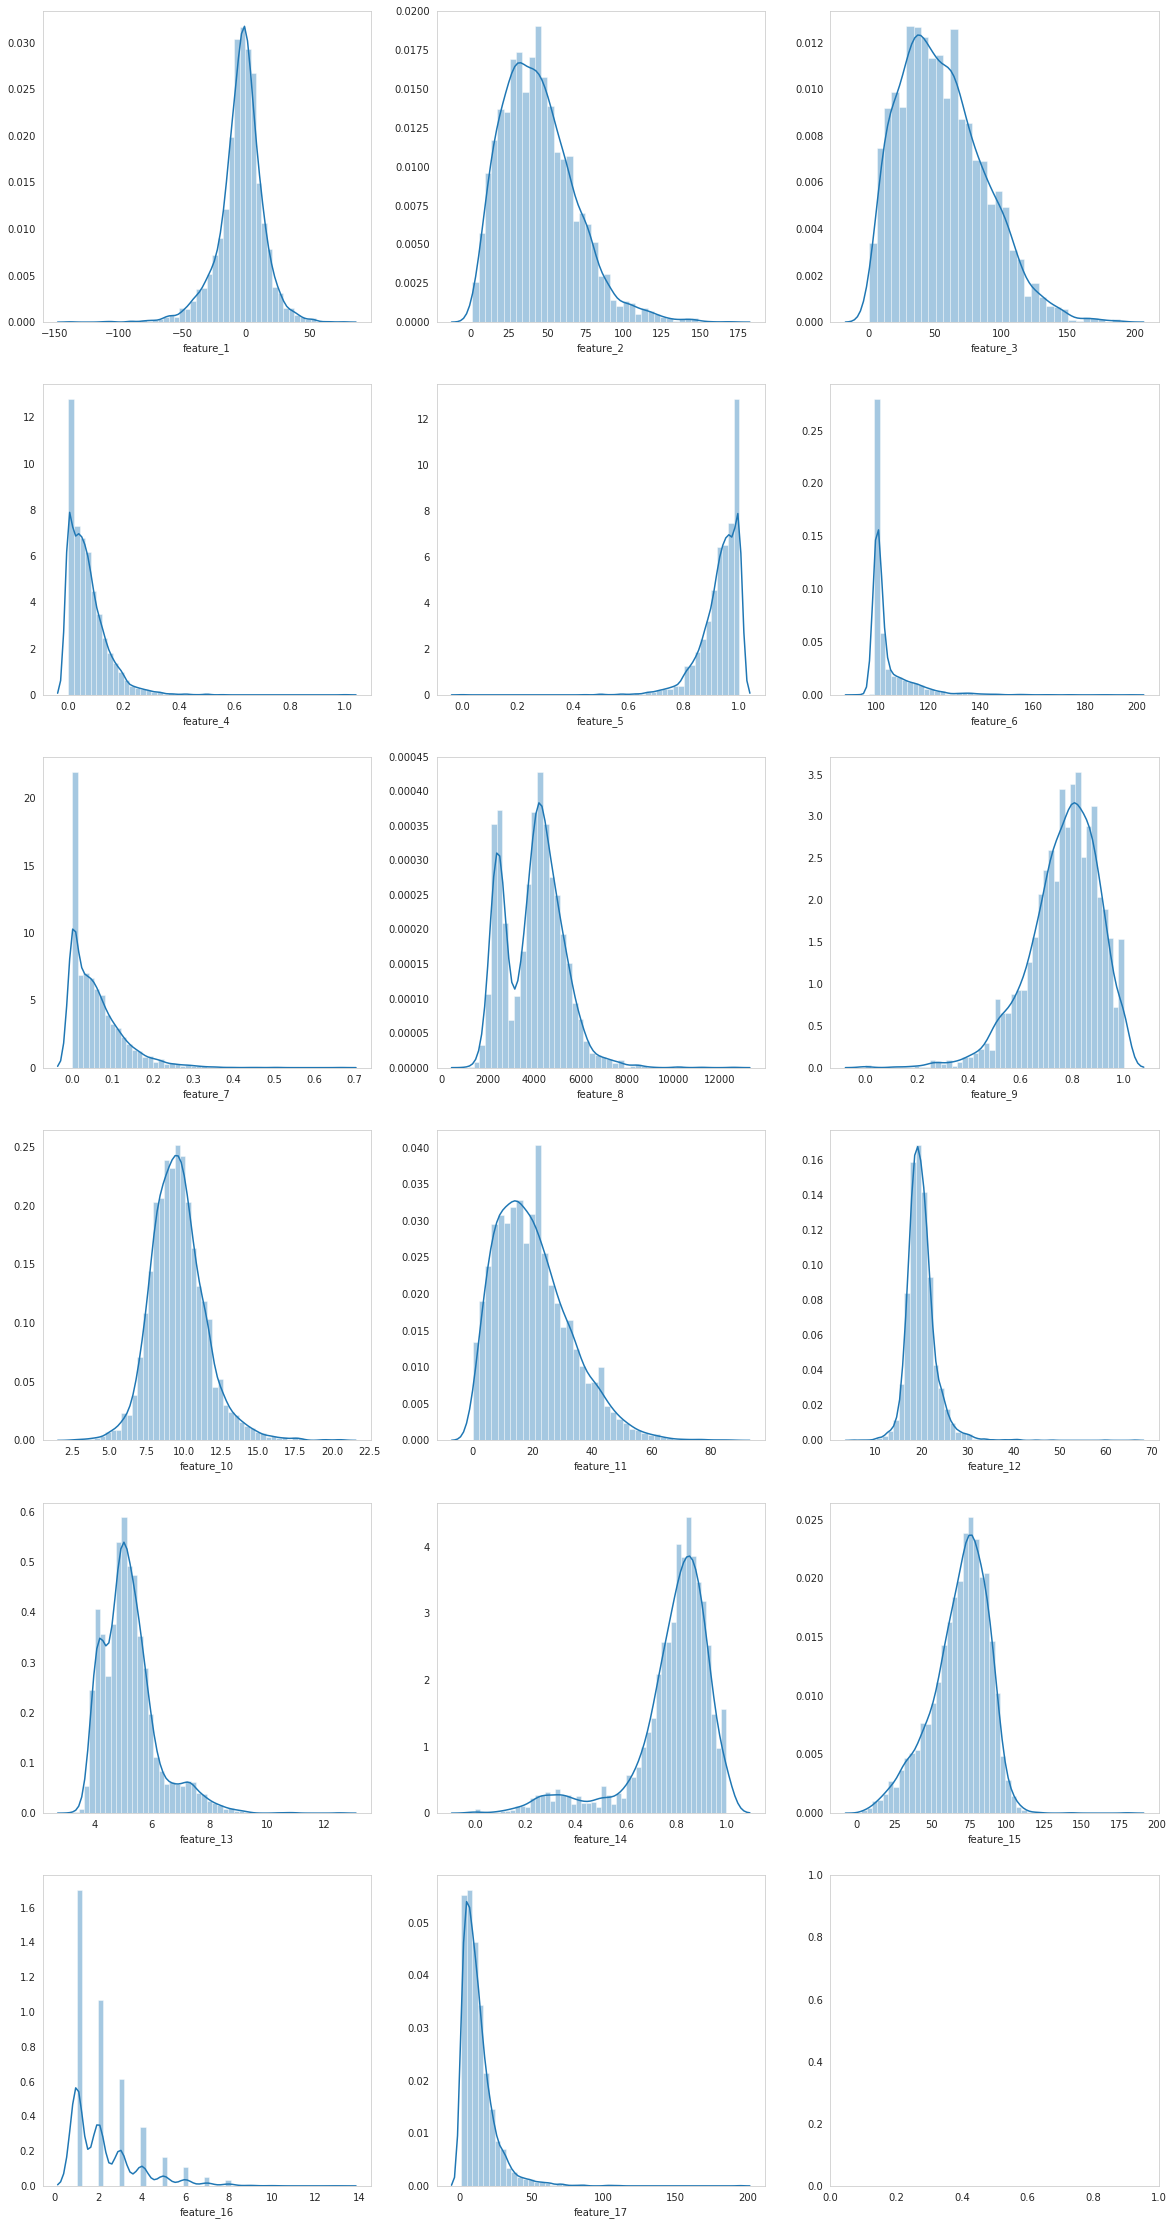

In [7]:
fig, axes = plt.subplots(6, 3, figsize=(20,40))
ax = axes.flatten() #ravel()

for i in range(len(weekly.columns[2:])):
    sb.distplot(weekly[weekly.columns[2:][i]], ax=ax[i])


### Clean data . Remove outliers by keeping data within -3std < data < +3std

In [8]:
outliers_ix = lifetime.index[np.abs(lifetime.feature_2-lifetime.feature_2.mean()) >= (3*lifetime.feature_2.std())]
lifetime.loc[outliers_ix, 'feature_2'] = np.NaN
for c in weekly.columns[2:]:
    outliers_ix = weekly.index[np.abs(weekly[c]-weekly[c].mean()) >= (3*weekly[c].std())]

In [9]:
lifetime.feature_2.describe()

count    6581.000000
mean       25.928430
std        11.587104
min        -1.000000
25%        20.000000
50%        25.000000
75%        32.000000
max        88.000000
Name: feature_2, dtype: float64

In [10]:
weekly[weekly.columns[2:]].describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
count,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.00000
mean,-3.702453,44.232208,55.691037,0.068610,0.931390,104.331502,0.059339,3975.807328,0.767527,9.619359,20.266942,20.000994,5.211435,0.782381,68.655642,2.255526,12.78941
std,17.407331,24.007116,31.666550,0.068999,0.068999,8.473348,0.064646,1237.055134,0.136458,1.827863,12.460020,3.205479,0.961980,0.164578,18.828885,1.542969,11.69108
min,-138.000000,1.000000,1.000000,0.000000,0.000000,92.857100,0.000000,1136.750000,0.000000,2.575000,0.000000,5.416667,3.270000,0.000000,2.957809,1.000000,1.00000
25%,-12.000000,26.000000,31.000000,0.018500,0.901200,100.000000,0.000000,2750.977800,0.693700,8.424751,11.000000,18.168824,4.570099,0.739100,57.839947,1.000000,5.00000
50%,-2.000000,41.000000,51.000000,0.054100,0.945900,100.465100,0.043500,4099.425000,0.785700,9.497961,19.000000,19.648810,5.072500,0.822200,71.653595,2.000000,10.00000
75%,6.000000,59.000000,76.000000,0.098800,0.981500,104.766000,0.088200,4774.028200,0.864200,10.607692,28.000000,21.335395,5.618522,0.883700,82.180556,3.000000,17.00000
max,77.000000,169.000000,189.000000,1.000000,1.000000,197.739100,0.666700,12593.900000,1.000000,20.546667,86.000000,66.400000,12.546923,1.000000,180.861111,13.000000,195.00000


### Explore distributions grouped by categories in lifetime feature 1 (a,b,c,d)
Check whether these categories affect the distributions of the weekly features  

In [11]:
#1st find couriers that do have weekly data to inspect the distributions
merge = pd.merge(lifetime, weekly, on='courier', how='right') #.to_csv('merge.csv')

#Get also the complete dataset. Lots of couriers will have lifetime data but no weekly data:
merge_all = pd.merge(lifetime, weekly, on='courier', how='left') #.to_csv('merge.csv')

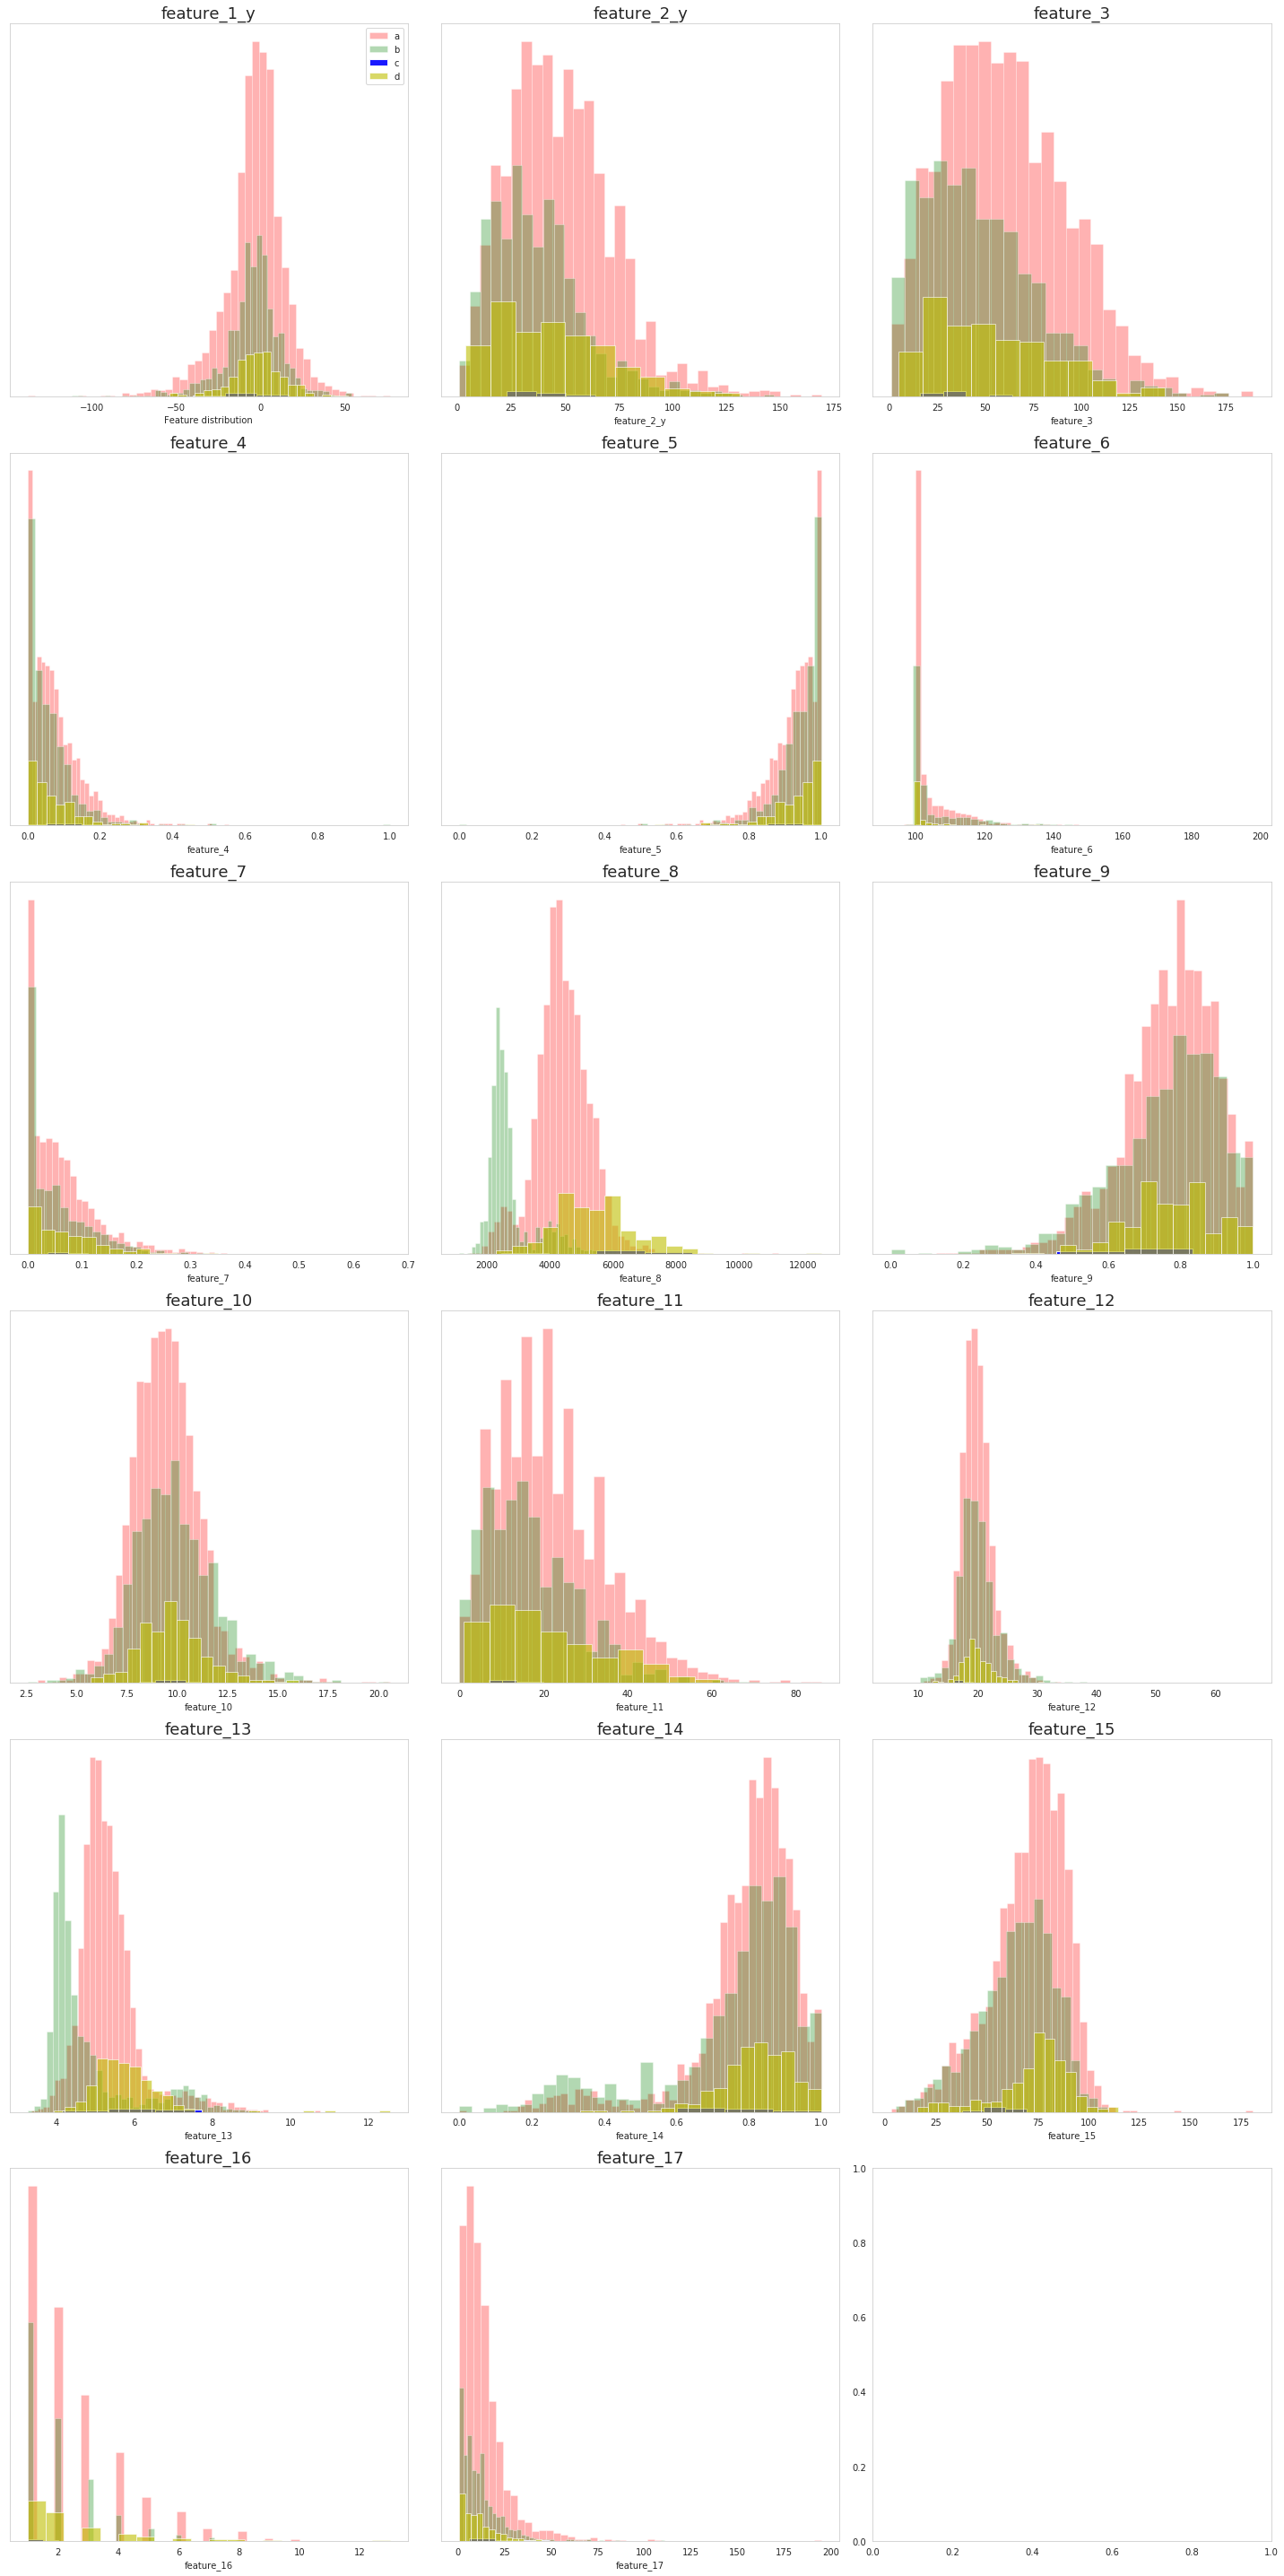

In [12]:
a = merge.loc[merge.feature_1_x=='a']
b = merge.loc[merge.feature_1_x=='b']
c = merge.loc[merge.feature_1_x=='c']
d = merge.loc[merge.feature_1_x=='d']

weekly_features = merge.columns[4:] 

fig, axes = plt.subplots(6, 3, figsize=(20,40))

ax = axes.flatten() #ravel()

for i in range(len(weekly_features)):
    sb.distplot(a[weekly_features[i]], ax=ax[i], color='r', hist_kws={'alpha':0.3}, kde=False, norm_hist=False)
    sb.distplot(b[weekly_features[i]], ax=ax[i], color='g', hist_kws={'alpha':0.3}, kde=False, norm_hist=False)
    sb.distplot(c[weekly_features[i]], ax=ax[i], color='b', hist_kws={'alpha':0.9}, kde=False, norm_hist=False)
    sb.distplot(d[weekly_features[i]], ax=ax[i], color='y', hist_kws={'alpha':0.6}, kde=False, norm_hist=False)
    ax[i].set_title(weekly_features[i], fontsize=18)
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature distribution")
ax[0].legend(["a", "b", "c", "d"], loc="best")
fig.tight_layout()


plt.show()

* Some of the features are clearly dependent on lifetime's feature 1. Like feature 8 and feature 13 where group b has lower values
* Category a has the most weekly data. In other words, most of the couriers that have weekly data belong to a
* Category c has almost no weekly data

### Impute missing values using medians of couriers grouped by lifetime feature_1 and feature_2  
Since some of the weekly features depend on lifetime feature 1 it can be useful to impute weekly missing values based on it. 
For example, of 103 couriers with lifetime feature1 == 'a' and feature2 == 31.0  
43 of them have weekly data. Impute the remaining 60 ones with the median of the 43  
**Note:** weekly.week can not be imputed this way since it's not a continuous variable. This imputation is for weekly features 1 to 17

In [13]:
list_f1 = list(set(merge_all.feature_1_x))
list_f2 = list(set(merge_all[merge_all.feature_2_x.notnull()].feature_2_x))

data = pd.DataFrame
frames = []
for f1 in list_f1:
    for f2 in list_f2:
        df = merge_all.loc[merge_all.feature_1_x==f1][merge_all.feature_2_x==f2]
        if len(df.dropna())>0: #some feature 1, feature 2 combinations don't have any weekly data at all
            df = df.fillna(df[weekly_features].dropna().median())
            frames.append(df)
        else:
            df = df.fillna(merge_all.loc[merge_all.feature_1_x==f1].dropna().median())
            frames.append(df)
#And then for the 1227 couriers that have feature_1 but no feature_2 just impute the median of the whole group a, b, c, d
for f1 in list_f1:
    df = merge_all[merge_all.feature_2_x.isnull()][merge_all.feature_1_x==f1]
    df = df.fillna(df[weekly_features].dropna().median())
    frames.append(df)
    
data = pd.concat(frames)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### But in the imputed dataset, lifetime feature 2 still has missing values. KNN-predict

In [14]:
missing_f2 = len(data[data['feature_2_x'].isnull()])
print("rows missing feature_2_x: %s"%missing_f2)

rows missing feature_2_x: 1227


In [15]:
#With the imputed data knn-predict the missing lifetime feature_2 values:
X = np.matrix(data[data['feature_2_x'].notnull()][weekly_features])
y = np.matrix(data['feature_2_x'].dropna()).T

#k = 5 by default
regr = KNeighborsRegressor().fit(X, y)
feature_2_x_ = regr.predict(np.matrix(data[weekly_features]))
data['feature_2_x_'] = feature_2_x_ 
#Replace the missing values in feature_2_x with the knn-predicted feature_2_x_ values
missing_f2_ix = data.index[data.feature_2_x.isnull()]
predicted_f2  = data[data.feature_2_x.isnull()].feature_2_x_
data.loc[missing_f2_ix, 'feature_2_x'] = predicted_f2
data.sample(10)

,courier,feature_1_x,feature_2_x,week,feature_1_y,feature_2_y,feature_3,feature_4,feature_5,feature_6,...,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_2_x_
145,12289,a,27.8,NaN,-2.0,58.0,64.5,0.0796,0.9204,100.34885,...,0.74025,9.096643,23.0,19.402681,5.449614,0.7807,71.167403,2.0,12.0,27.8
5257,454728,a,29.0,1.0,-18.0,40.0,36.0,0.0278,0.9722,101.38890,...,0.88890,11.781481,15.0,22.698333,4.847222,0.8889,59.587500,3.0,11.0,41.0
4150,379169,d,37.8,0.0,1.0,11.0,6.0,0.0000,1.0000,100.00000,...,0.50000,8.077783,2.0,16.420000,6.678333,0.6667,32.101010,2.0,1.0,37.8
7087,519301,b,24.0,5.0,-29.0,44.0,63.0,0.0159,0.9841,101.26980,...,0.85710,11.754762,30.0,30.570159,4.328889,0.8889,80.587753,4.0,27.0,30.6
1683,172699,a,58.0,5.0,-6.0,64.0,92.0,0.0761,0.9239,102.93480,...,0.83700,10.041485,35.0,18.647065,5.529348,0.8370,87.313802,3.0,10.0,38.4
4083,378810,a,40.0,1.0,-45.0,45.0,73.0,0.0274,0.9726,106.52050,...,0.67120,6.631281,15.0,18.537534,4.996849,0.7534,80.818519,4.0,23.0,34.4
331,40899,a,27.8,NaN,-2.0,58.0,64.5,0.0796,0.9204,100.34885,...,0.74025,9.096643,23.0,19.402681,5.449614,0.7807,71.167403,2.0,12.0,27.8
814,103832,a,40.0,2.0,10.0,103.0,36.0,0.0833,0.9167,100.00000,...,0.75000,13.037956,19.0,22.677500,5.138056,0.7778,22.116505,1.0,13.0,40.0
2708,279715,a,27.2,2.0,-2.0,92.0,122.0,0.0574,0.9426,111.48360,...,0.77870,7.779233,32.0,20.058689,5.582049,0.8197,67.235507,4.0,15.0,27.2
9382,829695,b,19.0,NaN,-2.0,36.0,44.0,0.0250,0.9750,101.17650,...,0.84620,10.035027,15.0,19.725316,4.325714,0.8481,65.561845,2.0,15.0,19.0


## Inspect correlation between features. Correlation plot and Heatmap

* Note the correlation plot below is also available here [correlogram.png](correlogram_notebook.png)

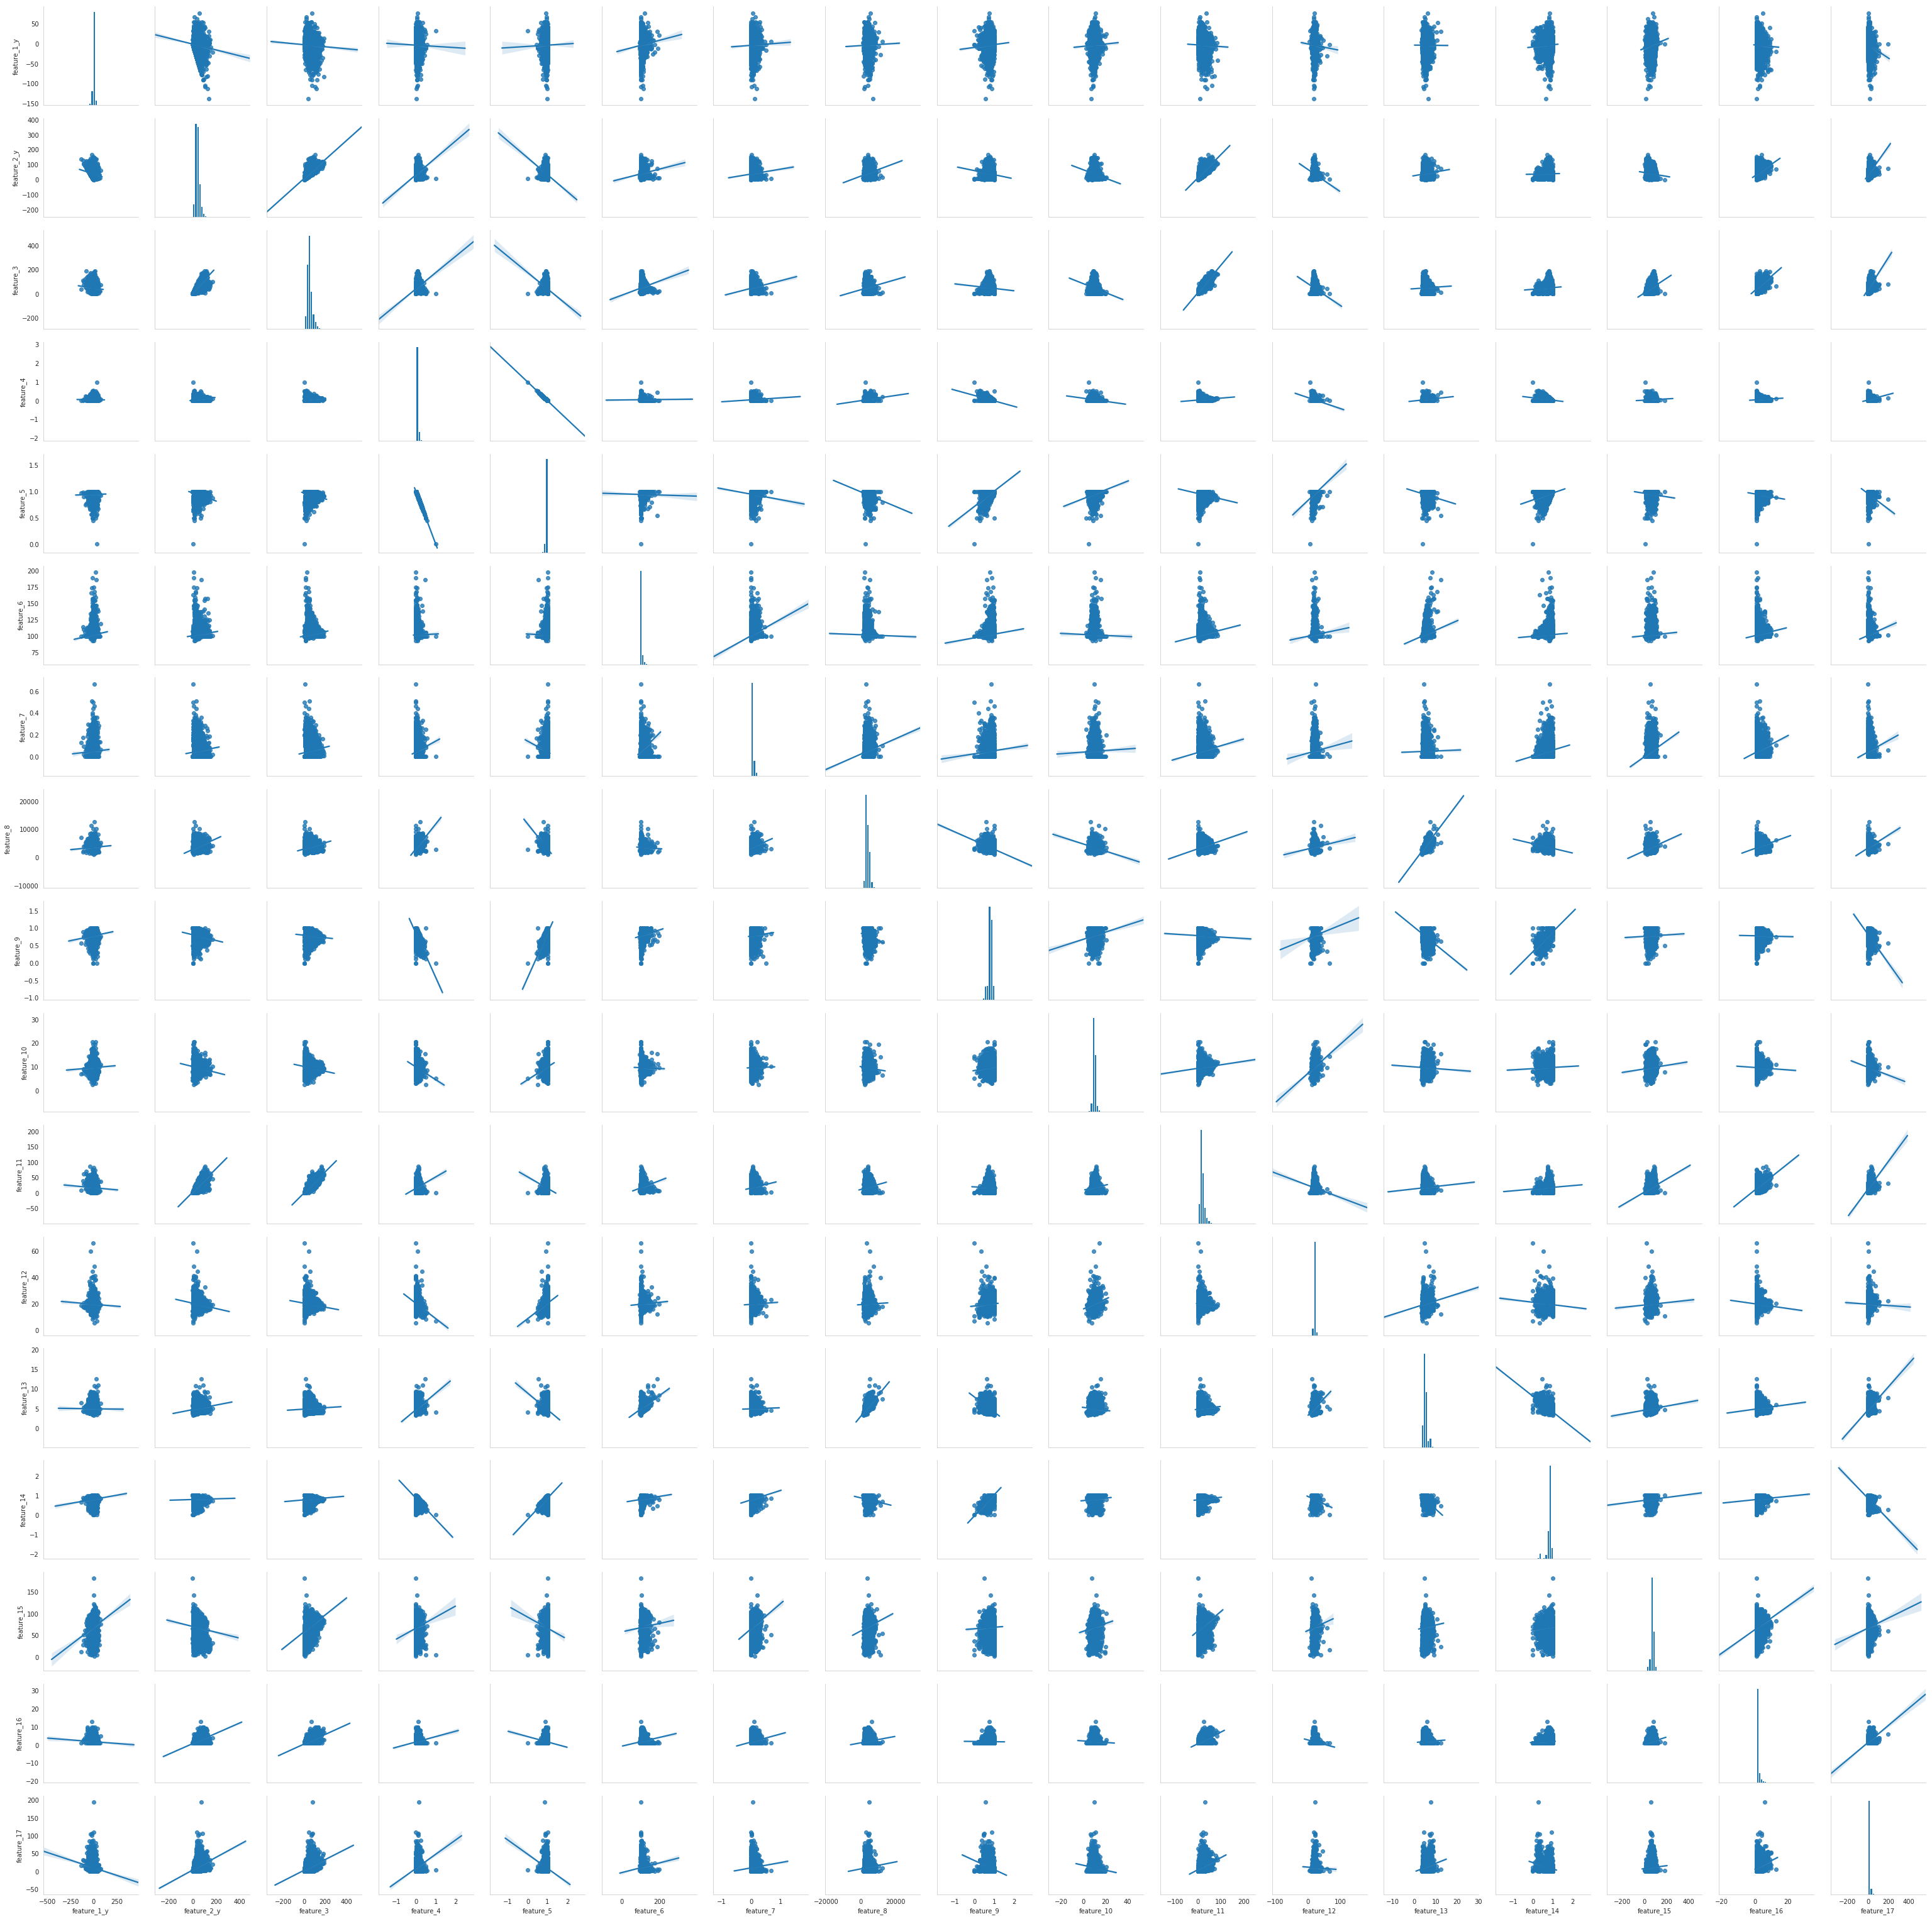

In [15]:
sb.pairplot(data[weekly_features], kind="reg")
plt.show()

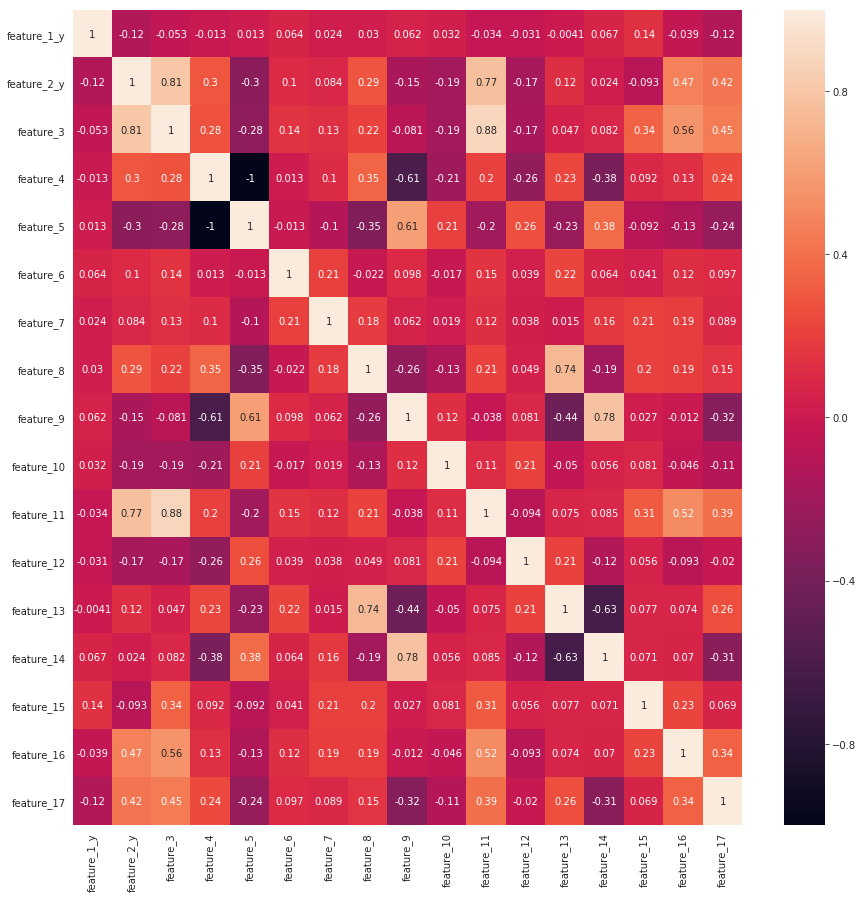

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(data[weekly_features].corr(), annot=True)

* feature 2 and feature 3:  0.81
* feature 2 and feature 11: 0.77
* feature 3 and feature 11: 0.88
* feature 4 and feature 5:  -1
* feature 8 and feature 13: 0.74
* feature 9 and feature 14: 0.78

### Label data. If a specific courier’s week 9, 10 and 11 data is not provided, label this courier as “1” otherwise “0”. After labeling, remove week 8(Yes including 8!), 9, 10 and 11 data to avoid bias in classification

In [16]:
#If ALL 9,10,11 are missing, label the courier "1"
#If it has ONE OF 9,10,11 label the courier "0"


data['label'] = ''*len(data)

grouped = data.groupby('courier')

couriers1 = list(set(grouped.filter(lambda x: x.week.max() < 9).courier))
couriers0 = list(set(grouped.filter(lambda x: x.week.max() >= 9).courier))

data.loc[data[data.courier.isin(couriers1)].index, 'label'] = 1
data.loc[data[data.courier.isin(couriers0)].index, 'label'] = 0

#there are a lot of couriers that don't have week data (bc they didn't have weekly data at all). Label those 1
data.loc[data[data.label==''].index, 'label'] = 1 

#Remove week 8 and following
data = data[data.week < 8]

## Create a logistic regression model to classify the labels

### First run the model with default parameters

In [17]:
# split data into a train set and test set. Get also the y targets (labels)
x_train, x_test, y_train, y_test = train_test_split(data[weekly_features], data.label, test_size=0.25, random_state=0)

###  K Nearest Neighbors classifier

In [92]:
#1st try default parameters
knn_clf = \
KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto',
                     leaf_size=30, p=2, metric='minkowski', metric_params=None)

 
#run the classifier with default params first
knn_clf.fit(x_train, y_train)
predictions = knn_clf.predict(x_test)


In [93]:
print(confusion_matrix(y_test,predictions))


[[390  93]
 [157 245]]


* TP, FP
* TN, FN
 
 TP, True  Positives:  number of couriers0 that have been correctly classified as "0"  
 FP, False Positives:  number of couriers1 that have been incorrectly classified as "0"  
 TN, True  Negatives:  number of couriers1 that have been correctly classifed as "1"  
 FN, False Negatives:  number of couriers0 that have been incorrectly classifed as "1"  

In [94]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.71      0.81      0.76       483
          1       0.72      0.61      0.66       402

avg / total       0.72      0.72      0.71       885



* precison = TP / (TP+TN) Proportion of correctly labeled 0 among all correct assignments
* recall   = TP / (TP+FP) Proportion of correctly labeled 0 among all labeled 0
* f1-score = 2 (precision recall) / (precision + recall)

In [95]:
print(accuracy_score(y_test,predictions))

0.7175141242937854


The accuracy score is a good metric for assessment of the model quality especially for simple binary classification like in this case. It just computes the number of correct predictions made divided by the total number of predictions made, usually multiplied by 100 to turn it into a percentage.  

Without any parameter tweaking the model assigns correctly 71% of the labels.  

But in addition to the accuracy it is important to know the number of False Positives and False Negatives, in this respect, the classifier does't perform great, especially assigning label "1" to couriers that are really "0". Lots of False Negatives  

### Tune up hyper-parameters. Run model again. See improvement

#### GridSearch
The Grid Search method will evaluate the results of the classifier for each possible combination of hyper parameters (stated in *params*) It is a good choice to find the best parameters when the dataset is not too large and the number of parameters to tune is small so the number of possible combinations is not too huge. Otherwise it is computationally expensive and can take very long time

In [22]:
params = {"n_neighbors": np.arange(1, 31, 2),
          "metric": ["euclidean", "cityblock", "cosine"],
          "weights":["uniform", "distance"],
          "leaf_size": np.arange(20,41)}

grid = GridSearchCV(KNeighborsClassifier(), params)
grid.fit(x_train, y_train)
print(grid.best_params_)

{'weights': 'uniform', 'leaf_size': 20, 'metric': 'cosine', 'n_neighbors': 7}


In [28]:
# Try KNeighborsClassifier again with the best_params_
knn_clf_gs = \
KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='cosine', leaf_size= 20)

knn_clf_gs.fit(x_train, y_train)
predictions = knn_clf_gs.predict(x_test)

In [29]:
print(confusion_matrix(y_test,predictions))

[[389  94]
 [135 267]]


In [30]:
print(classification_report(y_test, predictions))


             precision    recall  f1-score   support

          0       0.74      0.81      0.77       483
          1       0.74      0.66      0.70       402

avg / total       0.74      0.74      0.74       885



In [31]:
print(accuracy_score(y_test,predictions))

0.7412429378531074


The obtained accuracy score is slightly higher than what we get from the model using the default parameters. 
The TP are more and FP are fewer, so that is good news.
On the other hand the number of FN is even higher which is bad

#### Randomized search
The values for the hyperparameters are sampled from their distributions. The model is then evaluated for a pre-set number of times. Unlike Grid Search this method is not exhaustive but it is quite effective for exploring large spaces like the combinations of hyperparameters

In [57]:
params = {'n_neighbors': np.arange(1,101),
          "metric": ["euclidean", "cityblock", "cosine"],
          "weights": ["uniform", "distance"],
          "leaf_size": np.arange(1,101),
          "p": [1,2,3]}

grid = RandomizedSearchCV(knn_clf, params, n_iter=1000)
grid.fit(x_train, y_train)
print(grid.best_params_)

{'weights': 'uniform', 'n_neighbors': 8, 'leaf_size': 65, 'p': 2, 'metric': 'cosine'}


In [58]:
knn_clf_rs = \
KNeighborsClassifier(weights= 'uniform', n_neighbors=8, leaf_size=65, metric='cosine', p=2)

knn_clf_rs.fit(x_train, y_train)
predictions = knn_clf_rs.predict(x_test)

In [59]:
print(confusion_matrix(y_test,predictions))

[[414  69]
 [158 244]]


In [60]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.72      0.86      0.78       483
          1       0.78      0.61      0.68       402

avg / total       0.75      0.74      0.74       885



In [61]:
print(accuracy_score(y_test,predictions))

0.7435028248587571


The model performance increases even more with the hyperparameters found with the randomized search with fewer False Positives, the accuracy increases to 74%

### Logistic Regression classifier

In [62]:
logisticRegr = \
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

logisticRegr.fit(x_train, y_train)

predictions = logisticRegr.predict(x_test)

In [63]:
print(confusion_matrix(y_test,predictions))

[[329 154]
 [102 300]]


In [64]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.76      0.68      0.72       483
          1       0.66      0.75      0.70       402

avg / total       0.72      0.71      0.71       885



In [65]:
print(accuracy_score(y_test,predictions))

0.7107344632768362


#### GridSearch

In [66]:
params = {'penalty': ['l1','l2'],
          'C':   np.arange(0.1, 10, 0.1),
          'tol': np.arange(0.0001, 0.001, 0.0001)}
          
grid = GridSearchCV(LogisticRegression(), params)
grid.fit(x_train, y_train)
print(grid.best_params_)

{'tol': 0.00030000000000000003, 'C': 8.2, 'penalty': 'l2'}


In [67]:
#Try the Logistic Regression Model again with the obtained best_params from Grid Search
logisticRegr_gs = LogisticRegression(penalty='l2',tol=0.0003, C=8.2)
logisticRegr_gs.fit(x_train, y_train)
predictions = logisticRegr_gs.predict(x_test)

In [68]:
print(confusion_matrix(y_test,predictions))

[[327 156]
 [105 297]]


In [69]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.76      0.68      0.71       483
          1       0.66      0.74      0.69       402

avg / total       0.71      0.71      0.71       885



In [70]:
print(accuracy_score(y_test,predictions))

0.7050847457627119


#### Randomized search

In [85]:
params = {'penalty': ['l1','l2'],
          'tol': np.arange(0.0001, 1000, 0.0001),
          'C': np.arange(0.0001, 1000, 0.0001)}

grid = RandomizedSearchCV(LogisticRegression(), params, n_iter=1000)
grid.fit(x_train, y_train)
print(grid.best_params_)

{'tol': 1.1008, 'C': 260.3702, 'penalty': 'l1'}


In [86]:
#Try the Logistic Regression Model again with the obtained best_params from randomized search
logisticRegr_best = LogisticRegression(penalty='l1', C=260, tol=1.1)
logisticRegr_best.fit(x_train, y_train)
predictions = logisticRegr_best.predict(x_test)

In [87]:
print(confusion_matrix(y_test,predictions))

[[342 141]
 [169 233]]


In [88]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.67      0.71      0.69       483
          1       0.62      0.58      0.60       402

avg / total       0.65      0.65      0.65       885



In [89]:
print(accuracy_score(y_test,predictions))

0.6497175141242938


The performance of the Logistic Regression Model with the default parameters is similar to that of the KNN classifier
Interestingly, for the Logistic Regression Model, the tuning of hyperparameters decreases the accuracy score compared to that from the model with default parameters 
One explanation for this might be that the optimal values for "C" and "tol" might not be within the provided range of values 